# Redes Neuronales Artificiales - Trabajo Práctico 1

### Guillermina Cabrol, Magalí Giansiracusa, Sofía Goldberg



## Introducción

En este trabajo implementaremos modelos de redes neuronales artificiales para aprendizaje supervisado, para dos problemas distintos: **Diagnóstico de cáncer de mamas** y **Eficiencia energética**. Se hará un análisis de los datos obtenidos y los modelos construidos.

Las principales librerías que serán utilizadas para el desarrollo de los modelos son `Numpy` y `Matplotlib`. También usaremos `requests` para cargar los datos y `random` para generar seeds necesarias para que los resultados sean reproducibles.

In [1]:
import numpy as np 
from matplotlib import pyplot as plt
import requests
import random

Creamos una función para separar los datos en entrenamiento (`train`), validación (`val`) y testeo (`test`). Como sus nombres indican, usaremos los datos de entrenamiento para entrenar la red, los de validación para comprobar qué tan bien predice la red para datos no utilizados en el entrenamiento y poder ajustar parámetros para mejorar la performance, y por último, usaremos el dataset de testeo para calificar el modelo final y estimar su desempeño en la realidad.

In [2]:
from math import ceil, floor

def split(
        X: np.ndarray,
        Z: np.ndarray,
        train_size: float,
        val_size: float,
        test_size: float,
    ) -> tuple:

    """Separa el conjunto de datos en conjuntos de train, validation y test al azar.

    Parameters
    ----------
    X: datos de entrada.
    
    Z: datos objetivo.
    
    train_size: proporción del dataset a incluir en train.

    val_size: proporción del dataset a incluir en validation.

    test_size: proporción del dataset a incluir en test.

    random_state: sirve para que los resultados sean reproducibles.

    Returns
    -------
    split: lista que contiene el conjunto de test y el de train.
    """

    n = len(X)

    n_test = ceil(test_size * n)
    n_train = floor(train_size * n)
    n_val = ceil(val_size * n)

    n_train, n_test, n_val = int(n_train), int(n_test), int(n_val)


    X_train = X[:n_train]
    X_val = X[n_train:n_train + n_test]
    X_test = X[n_train + n_test:]

    Z_train = Z[:n_train]
    Z_val = Z[n_train:n_train + n_test]
    Z_test = Z[n_train + n_test:]

    return X_train, Z_train, X_val, Z_val, X_test, Z_test

## Implementación

A continuación, definimos la clase del modelo a utilizar, en el cual vamos a variar la cantidad de capas de la red y la distribución de nodos por capa para obtener intentar obtener una red neuronal que prediga los datos objetivo.

- En primer lugar, el **constructor** de la clase inicializa las variables necesarias para la red neuronal.

- En la **activación**, se itera a través de las capas de la red y se utiliza la función tanh (tangente hiperbólica) para calcular la activación. En cada iteración, se guarda el valor de activación de las unidades en Yk.

- En la **corrección**, se realiza la retro-propagación del error. Se calcula E, el error entre la salidad de la red neuronal y los objetivos(parámetro que recibe), y luego calcula los gradientes de las salidas de cada capa, para así calcular la corrección de los pesos. Además, en cada iteración, se calcula la derivada de la función de transferencia. Cuando esto se termina de ejecutar, se realiza *backpropagation* para calcular la estimación del error.

- En la **adaptación**, se itera a través de las capas y se actualizan los pesos (W) agregando las correcciones de los mismos (dW), multiplicado por la tasa de aprendizaje (lr).

- En la **estimación**, se calcula el error cuadrático medio entre las salidas de la red neuronal y los objetivos. 

- En el **entrenamiento**, la red neuronal se entrena utilizando el algoritmo de retropropagación durante un número especificado de épocas. Las épocas remiten a  la cantidad de veces que la red neuronal completa un paso de entrenamiento utilizando todo el conjunto de entrenamiento. Para que se recorran las instancias en orden aleatorio sin repetición, utilizamos el método permutation. En cada época, se realiza el entrenamiento en mini lotes. Los mini lotes consisten en una división del conjunto de entrenamiento en lotes más pequeños para entrenar la red neuronal de manera incremental.

- En la **validación**, se aplica la activación al conjunto de validación y luego se estima el error del modelo para estos datos.

- Por último, decidimos implementar funciones privadas, las cuales van a ser utilizadas internamente por las funciones anteriormente descriptas y toman el rol de inicializar distintas variables y manipular los datos durante el proceso de entrenamiento y retropropagación del error de la red neuronal.

Más adelante, presentaremos los dos problemas a intentar resolver en este trabajo, donde el primero es de clasificación y el segundo de regresión.

En el caso de clasificación, donde buscamos determinar a qué clase pertenece una instancia, utilizamos la función de activación $tanh$ en todas las capas. El único problema con esto es que buscamos valores de salida entre $0$ y $1$, y $tanh$ devuelve valores en el intervalo $(-1, 1)$.

Por otro lado, en el problema de regresión, no podemos utilizar $tanh$ como activación en la última capa, porque esa función tiene una imagen de $(-1, 1)$: si la usáramos, la red neuronal no podría modelar ninguna función que devuelva valores afuera de ese intervalo. En cambio, decidimos usar la función ReLU (sólo para la última capa).

Al realizar este cambio, empezamos a obtener errores de *overflow*. Después de investigar sobre el problema, nuestra mejor hipótesis es que estamos ante el problema de *exploding gradients*, donde los gradientes se acumulan hasta llegar a una magnitud demasiado alta. Para solucionarlo, implementamos *gradient clipping*, limitando la magnitud máxima de los gradientes.

In [128]:
class MLP:
    def __init__(self, units_per_layers, lr):
        self.S = units_per_layers
        self.L = len(self.S)
        self.Y = []
        self.W = self._initialize_W()
        self.dW = self._initialize_dW()
        self.lr = lr

    def activation(self, X):
        self.Y = self._initialize_Y(X)
        activation = X

        for k in range(1, self.L):
            self.Y[k - 1] = self._bias_add(activation)
            if k == self.L - 1:
                activation = np.maximum(self.Y[k - 1] @ self.W[k], 0)
            else:
                activation = np.tanh(self.Y[k - 1] @ self.W[k])

        self.Y[self.L - 1] = activation

    def correction(self, Z):
        E = Z - self.Y[self.L - 1]
        dY = np.where(self.Y[self.L - 1] > 0, 1, 0)

        D = [np.empty_like(y) for y in self.Y]
        D[self.L - 1] = E * dY

        for k in range(self.L - 1, 0, -1):
            self.dW[k] = self.lr * (self.Y[k - 1].T @ D[k])

            if k == self.L - 1:  # Gradient clipping para la última capa
                max_grad_norm = 1.0
                grad_norm = np.linalg.norm(self.dW[k])
                if grad_norm > max_grad_norm:
                    self.dW[k] = self.dW[k] * (max_grad_norm / grad_norm)

            E = D[k] @ self.W[k].T
            dY = 1 - np.square(self.Y[k - 1])
            D[k - 1] = self._bias_sub(E * dY)

    def adaptation(self):
        for k in range(1, self.L):
            self.W[k] += self.dW[k]

    def estimation(self, Z):
        return np.mean(np.square(Z - self.Y[self.L - 1]))

    def train(self, X, Z, epochs, batch_size, print_error=True, plot_error=True):
        errores = []
        rng = np.random.default_rng(seed=42)
        for i in range(epochs):
            e = 0
            indices = rng.permutation(len(X))
            for h in range(0, len(indices), batch_size):
                batch = indices[h : h + batch_size]
                Xh = X[batch]
                Zh = Z[batch]
                self.activation(Xh)
                self.correction(Zh)
                self.adaptation()
                e += self.estimation(Zh)

            errores.append(e)
            if print_error and i % 100 == 0:
                print(i, e)

        if plot_error:
            plt.plot(errores, "r")
            plt.show()

        return self.W

    def validation(self, X, Z):
        self.activation(X)
        return self.estimation(Z)

    ## Funciones privadas

    def _bias_add(self, V):
        bias = np.ones((len(V), 1))
        return np.hstack([V, bias])

    def _bias_sub(self, V):
        return V[:, :-1]

    def _initialize_Y(self, X):
        P = X.shape[0]
        Y = [np.empty((P, self.S[i] + 1)) for i in range(self.L)]
        Y[self.L - 1] = np.empty((P, self.S[self.L - 1]))
        return Y

    def _initialize_W(self):
        W = []
        W.append(np.array([]))
        W.extend(
            np.random.RandomState(seed=42).normal(
                0, 0.5, (self.S[i - 1] + 1, self.S[i])
            )
            for i in range(1, self.L)
        )
        return W

    def _initialize_dW(self):
        dW = [np.empty_like(w) for w in self.W]
        return dW


Para poder decidir cuál es la mejor combinación de hiperparámetros a utilizar, armamos una función de *grid search*. La misma, va por todas las combinaciones de hiperparámetros dadas y se queda con la que obtenga el menor error. 

Para el caso de la cantidad de nodos en cada capa y la cantidad de capas, armamos una función (que está definida dentro del grid search) que genere todos los conjuntos de 0 a 4 capas ocultas, donde la capa de entrada será de N nodos y la de salida de M. Si no se le pasan parámetros para S al grid search, se tomarán los resultados de esta función. Los valores posibles para los demás hiperparámetro son definidos al momento de llamar a la función, y se pasan en un diccionario.


In [75]:
from itertools import product


def grid_search(X_train, Z_train, X_val, Z_val, N, M, params):

    def all_possible_S(hidden_layers):
        all_S = [[N, M]]
        for _ in range(1, hidden_layers + 1):
            next_S = []
            for prev_S in all_S:
                for i in [2, 4, 8, 32]:
                    next_S.append(prev_S[:-1] + [i] + prev_S[-1:])
            all_S.extend(next_S)
        return all_S

    min_error = float('inf')
    best_params = []
    all_combinations = list(product(params.get('S') or all_possible_S(5), params['b_size'], params['lr'], params['epochs']))

    for layers, b_size, lr, epoch in all_combinations:
        modelo = MLP(units_per_layers=layers, lr=lr)
        modelo.train(X_train, Z_train, epoch, b_size, print_error=False, plot_error=False)

        error = modelo.validation(X_val, Z_val)
        if error < min_error:
            min_error = error
            best_params = [layers, b_size, lr, epoch]

    print(f' El mínimo error obtenido es: {min_error}')
    print(f'Usando los parámetros: S: {best_params[0]}, b_size: {best_params[1]}, lr: {best_params[2]}, epoch: {best_params[3]}')

En el código de la celda anterior utilizamos la librería `itertools`, para obtener la función `product`, que realiza el producto cartesiano entre los elementos de cada una de las listas. Esto es para hacer más legible el código (sino se tendrían varios fors anidados).


## Diagnóstico de cáncer de mamas

Tenemos un conjunto de datos con los resultados para distintos pacientes de un examen para determinar si tienen cáncer de mamas maligno o benigno. Cada columna representa una característica obtenida en el examen realizado, y el objetivo será determinar si es posible predecir el diagnóstico final utilizando una red neuronal.

Primero, cargamos los datos, y los separamos en X (datos de entrada) y Z (datos objetivo).

In [85]:
r = requests.get('https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp1_ej1_training.csv')
data = np.loadtxt(r.iter_lines(), delimiter=',')

data = np.random.RandomState(seed=42).permutation(data)

X1 = data[:,1:]

Z1 = data[:,0:1]

Dividimos los datos:

- 80% para entrenamiento.
- 15% para validación.
- 5% para testeo.

In [86]:
X_train1, Z_train1, X_val1, Z_val1, X_test1, Z_test1 = split(X1, Z1, 0.8, 0.15, 0.05)

### Análisis de datos

Vamos a realizar un análisis de los datos de entrenamiento para ver su distribución y cuán correlacionados están, para así decidir si es necesario realizar alguna modificación.

Para esto, pasaremos los datos a formato *DataFrame* usando la librería `Pandas`.

In [90]:
import pandas as pd

df = pd.DataFrame(X_train1, columns=['Radio', 'Textura', 'Perímetro', 'Área', 'Suavidad', 'Compacidad', 'Concavidad', 'Puntos cóncavos', 'Simetría', 'Dimensión fractal'])
df.describe()

,Radio,Textura,Perímetro,Área,Suavidad,Compacidad,Concavidad,Puntos cóncavos,Simetría,Dimensión fractal
count,328.000000,328.00000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000
mean,18.443460,21.35757,114.141232,867.459232,1.808732,1.866585,3.687707,4.575817,0.721192,1.572451
std,4.480139,6.23495,29.269280,402.135891,0.501887,0.615539,1.409734,2.015989,0.258994,0.621784
min,8.886000,9.71000,43.790000,143.500000,0.053000,0.387000,0.427000,0.434000,0.106000,0.050000
25%,15.323000,15.83450,93.670750,563.215000,1.594750,1.464000,2.683750,2.928250,0.542750,1.126500
50%,18.112500,22.32900,112.667000,771.372500,1.783500,1.863000,3.657000,4.574500,0.730000,1.628500
75%,21.642000,27.13900,136.933000,1128.434000,2.031500,2.258750,4.703500,6.229500,0.904000,2.031750
max,28.110000,33.81000,188.500000,2501.000000,4.163000,3.329000,6.817000,8.487000,1.304000,2.974000


Como podemos ver a simple vista, los datos de entrada presentan magnitudes diferentes entre sí, por lo que vamos a necesitar estandarizarlos, para lo cual le restamos a cada instancia su media y dividimos por su desvío estándar. Esto lo hacemos para tanto el conjunto de entrenamiento como el de test y el de validación, pero a éstos últimos se les resta la media y se divide por la varianza de los datos de entrenamiento, para aplicarle la misma transformación a todos los datos (no podemos usar la media general, porque estaríamos filtrando información de validación a las instancias de entrenamiento).

In [92]:
X_train1 = (X_train1 - X_train1.mean(axis=0)) / X_train1.std(axis=0)
X_test1 = (X_test1 - X_train1.mean(axis=0)) / X_train1.std(axis=0)
X_val1 = (X_val1 - X_train1.mean(axis=0)) / X_train1.std(axis=0)

Ahora las escalas de los datos ya no son tan distintas entre sí:

In [94]:
df = pd.DataFrame(X_train1, columns=['Radio', 'Textura', 'Perímetro', 'Área', 'Suavidad', 'Compacidad', 'Concavidad', 'Puntos cóncavos', 'Simetría', 'Dimensión fractal'])
df.describe()

,Radio,Textura,Perímetro,Área,Suavidad,Compacidad,Concavidad,Puntos cóncavos,Simetría,Dimensión fractal
count,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02
mean,1.965907e-15,1.126470e-15,1.367470e-15,-7.392461e-16,-1.435166e-15,-5.361565e-16,-4.346117e-16,9.964929e-16,-1.448706e-15,3.384826e-16
std,1.001528e+00,1.001528e+00,1.001528e+00,1.001528e+00,1.001528e+00,1.001528e+00,1.001528e+00,1.001528e+00,1.001528e+00,1.001528e+00
min,-2.136555e+00,-1.870964e+00,-2.407258e+00,-1.803036e+00,-3.503605e+00,-2.407395e+00,-2.316528e+00,-2.057623e+00,-2.378940e+00,-2.452261e+00
25%,-6.975739e-01,-8.871777e-01,-7.004531e-01,-7.577267e-01,-4.270057e-01,-6.550361e-01,-7.132487e-01,-8.184988e-01,-6.900333e-01,-7.183079e-01
50%,-7.398566e-02,1.560420e-01,-5.044484e-02,-2.393060e-01,-5.035048e-02,-5.833655e-03,-2.181562e-02,-6.543120e-04,3.406014e-02,9.027956e-02
75%,7.150284e-01,9.286784e-01,7.798822e-01,6.499631e-01,4.445395e-01,6.380808e-01,7.216570e-01,8.215371e-01,7.069160e-01,7.398072e-01
max,2.160939e+00,2.000249e+00,2.544387e+00,4.068368e+00,4.697999e+00,2.379457e+00,2.223166e+00,1.943046e+00,2.253711e+00,2.257519e+00


Ahora ya estamos en condiciones de entrenar nuestro modelo con los datos de entrenamiento. Primero haremos una prueba para asegurarnos de que la red esté aprendiendo y luego correremos el grid search para determinar con qué parámetros obtenemos los mejores resultados.

0 0.4365944405161715
100 0.24840995733370558
200 0.2468663478328134
300 0.24447681289795173
400 0.24221154657708588
500 0.24025205204899047
600 0.23841550541643994
700 0.2367495467082036
800 0.23527941631503924
900 0.23399946567223542
1000 0.23289754442383725
1100 0.23194171286828968
1200 0.23109325908492706
1300 0.23032089785886858
1400 0.22960481758198711
1500 0.2289355444054028
1600 0.22830871590729707
1700 0.2277184298313141
1800 0.2271539070645221
1900 0.2265989953510829
2000 0.22603009169198568
2100 0.22540613883021163
2200 0.22465597145495322
2300 0.22372330720227473
2400 0.22262588183097876
2500 0.22135196812980418
2600 0.21976391477401344
2700 0.21724929937745763
2800 0.2071791262825684
2900 0.1864575208581789
3000 0.16543644351259695
3100 0.15511709342667254
3200 0.1485146216207232
3300 0.13942435058448466
3400 0.10687114458937871
3500 0.08111513037212428
3600 0.06726540355808654
3700 0.05653045420494297
3800 0.0474812338304969
3900 0.04038861190881421
4000 0.0347406921433913

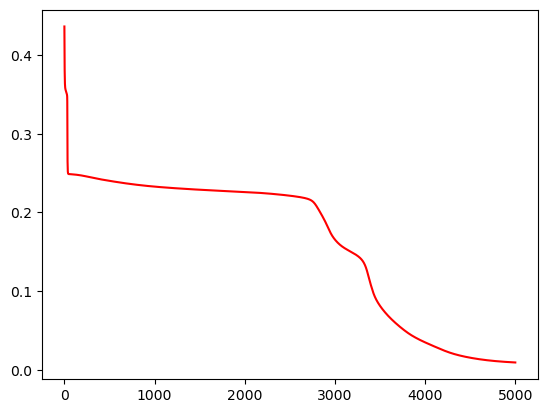

[array([], dtype=float64),
 array([[ 5.66807319e-01, -5.48621720e-01,  4.58711032e-01,
          1.21355038e+00, -3.34552329e-01,  3.92939849e-02,
          7.24911049e-01, -3.85142231e-01, -2.87456347e-01,
         -1.65125185e-01,  5.07514481e-01, -1.42026744e-01,
         -2.22078003e-01, -6.92670834e-01, -6.04344957e-01,
          1.38056805e-01],
        [-4.27022181e-01,  8.89863492e-01, -7.63955304e-01,
         -1.56238227e+00,  9.43147605e-01, -6.39023656e-02,
          6.48697454e-01,  3.98045708e-01, -2.95882395e-01,
          4.29034855e-01, -1.23160759e+00,  1.38243238e-01,
         -2.20445138e-01,  1.39596222e-02, -4.47760201e-01,
          1.25459963e+00],
        [ 7.60900309e-01, -1.01719057e+00,  5.20771319e-01,
         -7.98745133e-01,  2.01721040e-01, -1.19493757e+00,
         -1.31552604e+00, -2.58919098e-01,  2.79287463e-01,
          4.89262407e-01,  6.44043305e-01, -1.40439077e-01,
         -6.12590038e-01, -4.12337424e-01, -6.28995365e-01,
          6.2303438

In [122]:
modelo = MLP([10, 16, 1, 1], 0.001) 
modelo.train(X=X_train1, Z=Z_train1, epochs=5000, batch_size=len(X_train1))

In [123]:
modelo.validation(X=X_val1, Z=Z_val1)

0.4098590803812994

Luego de probar con varios valores para el tamaño de los lotes, llegamos a la conclusión de que la red predice mejor sin ellos, por lo que decidimos tomar siempre `batch_size` como la cantidad de instancias de train. Esto agiliza el tiempo que tarda en correr, tanto el grid search como el entrenamiento en sí.

Inicialmente, pensábamos correr el `grid_search` para una multitud de configuraciones de red distintas (se puede ver en la función interna `all_posible_S`). Sin embargo, por limitaciones de tiempo, decidimos buscar buenas estructuras a mano, y probar un grid search entre ellas.

Una propiedad notable de estas estructuras es que la última hidden layer cuenta con una única neurona. Esto se debe a que se utiliza la anteúltima capa (que tiene activación $tanh$) para obtener un valor en el intervalo $(-1, 1)$, para luego aplicarle ReLU y obtener una estimación de probabilidad (en el intervalo $(0, 1)$).

In [104]:
S_values = [[10, 16, 1, 1], [10, 16, 8, 1, 1], [10, 8, 8, 1, 1], [10, 32, 16, 8, 1, 1]]
b_size_values = [X_train1.shape[0]]
lr_values = [0.001, 0.01, 0.1]
epoch_values = [1000, 2000, 5000]

params = {
    "S": S_values,
    "b_size": b_size_values,
    "lr": lr_values,
    "epochs": epoch_values,
}

grid_search(X_train1, Z_train1, X_val1, Z_val1, N=10, M=1, params=params)


 El mínimo error obtenido es: 0.22378357384071093
Usando los parámetros: S: [10, 16, 8, 1, 1], b_size: 328, lr: 0.001, epoch: 5000


Los mejores parámetros encontrados para la red son:

- Usar 3 **capas ocultas**, con 16, 8 y 1 nodo/s respectivamente.
- **Learning rate** de 0.001.
- 5000 **epochs**.

Por último, testeamos nuestro modelos con el conjunto de test, usando los hiperparámetros que minimizan el error.

0 0.4771547026627088
100 0.24834859104425736
200 0.2471169029546335
300 0.24537552478586888
400 0.24245483991371086
500 0.23823471913972805
600 0.23503133787297267
700 0.232973054745347
800 0.23150927325063111
900 0.23039612172528046
1000 0.22950415743644578
1100 0.22876126576385203
1200 0.2281278660285978
1300 0.22758149847922382
1400 0.22710757361343162
1500 0.22669489811298582
1600 0.22633407568395383
1700 0.22601711081605358
1800 0.225737299659874
1900 0.22548910405791692
2000 0.22526797990398573
2100 0.22507019549780044
2200 0.2248926677162364
2300 0.22473282680171652
2400 0.22458850999475174
2500 0.22445787982276802
2600 0.2243393618499236
2700 0.22423159714858595
2800 0.22413340566620077
2900 0.2240437575889052
3000 0.22396175058472456
3100 0.2238865914112807
3200 0.2238175808134142
3300 0.22375410094818324
3400 0.22369560479154008
3500 0.22364160713024414
3600 0.22359167684518216
3700 0.22354543026328808
3800 0.2235025254050655
3900 0.22346265699033518
4000 0.22342555209090842


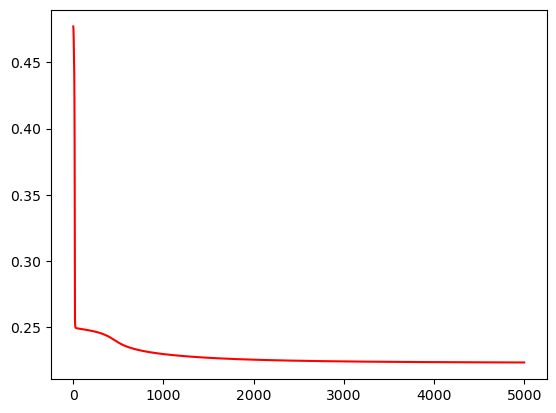

0.5413357307997523

In [124]:
modelo_final = MLP([10, 16, 8, 1, 1], 0.001)
modelo_final.train(X=X_train1, Z=Z_train1, epochs=5000, batch_size=len(X_train1))
modelo.validation(X=X_test1, Z=Z_test1)

Como es de esperarse, el error de testing es mayor al de validación, pero la diferencia no es tan significativa.

## Eficiencia de energía

Tenemos los datos de un análisis energético realizado en varios edificios, con 10 característica cada uno. A diferencia del caso anterior, donde el problema era de clasificación (decidir entre dos etiquetas, a cuál pertenece cada instancia), en este caso tenemos un problema de regresión: se quieren predecir dos valores: **Carga de calefacción** y **Carga de refrigeración**, los cuales representan la carga energética necesaria para la calefacción y refrigeración de un edificion.

El objetivo es el mismo, encontrar determinar si hay un modelo de redes neuronales que prediga la carga energética.

Cargamos los datos, y los separamos en X (datos de entrada) y Z (datos objetivo).

In [105]:
r = requests.get('https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp1_ej2_training.csv')
data = np.loadtxt(r.iter_lines(), delimiter=',')

data = np.random.RandomState(seed=42).permutation(data)

X2 = data[:,:-2]

Z2 = data[:,-2:] 

Dividimos los datos en train, validation y test, con las mismas proporciones que en la sección anterior.

In [106]:
X_train2, Z_train2, X_val2, Z_val2, X_test2, Z_test2 = split(X2, Z2, 0.8, 0.15, 0.05)

Nuevamente, queremos visualizar los datos para tener determinar si es necesario realizar algún tipo de normalización.

In [107]:
df = pd.DataFrame(X_train2, columns=['Compacidad Relativa', 'Área de la Superficie Total', 'Área de las Paredes', 'Área del techo', 'Altura Total', 'Orientación', 'Área de Reflejo Total', 'Distribución del Área de Reflejo'])
df.describe()

,Compacidad Relativa,Área de la Superficie Total,Área de las Paredes,Área del techo,Altura Total,Orientación,Área de Reflejo Total,Distribución del Área de Reflejo
count,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.760925,674.178750,318.68375,177.747500,5.223750,3.410000,0.228375,2.742500
std,0.104329,87.505087,44.51115,44.696863,1.751994,1.090814,0.133165,1.588238
min,0.620000,514.500000,245.00000,110.250000,3.500000,2.000000,0.000000,0.000000
25%,0.660000,612.500000,294.00000,147.000000,3.500000,2.000000,0.100000,1.000000
50%,0.740000,686.000000,318.50000,220.500000,3.500000,3.000000,0.250000,3.000000
75%,0.820000,759.500000,343.00000,220.500000,7.000000,4.000000,0.400000,4.000000
max,0.980000,808.500000,416.50000,220.500000,7.000000,5.000000,0.400000,5.000000


Al igual que antes, decidimos que lo mejor es restar la media de cada variable y dividir por el desvío estándar general:

In [108]:
X_train2 = (X_train2 - X_train2.mean(axis=0)) / X_train2.std()
X_test2 = (X_test2 - X_train2.mean(axis=0)) / X_train2.std()
X_val2 = (X_val2 - X_train2.mean(axis=0)) / X_train2.std()

Luego, podemos ver que las escalas de los datos son más uniformes:

In [109]:
df = pd.DataFrame(X_train2, columns=['Compacidad Relativa', 'Área de la Superficie Total', 'Área de las Paredes', 'Área del techo', 'Altura Total', 'Orientación', 'Área de Reflejo Total', 'Distribución del Área de Reflejo'])
df.describe()

,Compacidad Relativa,Área de la Superficie Total,Área de las Paredes,Área del techo,Altura Total,Orientación,Área de Reflejo Total,Distribución del Área de Reflejo
count,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02
mean,3.517152e-18,-1.598721e-16,1.124101e-16,-1.221245e-17,9.714451e-19,-6.418477e-19,6.581107e-19,-7.806256e-19
std,4.529626e-04,3.799175e-01,1.932524e-01,1.940587e-01,7.606568e-03,4.735945e-03,5.781578e-04,6.895592e-03
min,-6.118487e-04,-6.932711e-01,-3.199099e-01,-2.930513e-01,-7.483940e-03,-6.121743e-03,-9.915270e-04,-1.190701e-02
25%,-4.381822e-04,-2.677883e-01,-1.071685e-01,-1.334952e-01,-7.483940e-03,-6.121743e-03,-5.573608e-04,-7.565346e-03
50%,-9.084927e-05,5.132387e-02,-7.977804e-04,1.856169e-01,-7.483940e-03,-1.780081e-03,9.388844e-05,1.117978e-03
75%,2.564837e-04,3.704360e-01,1.055729e-01,1.856169e-01,7.711877e-03,2.561580e-03,7.451377e-04,5.459640e-03
max,9.511496e-04,5.831774e-01,4.246851e-01,1.856169e-01,7.711877e-03,6.903242e-03,7.451377e-04,9.801302e-03


Al igual que en la sección anterior, vamos a realizar un ejemplo para ver que la red esté aprendiendo y luego correremos `grid search` para determinar con qué hiperparámetros quedarnos.

0 634.450015625
100 634.4500156250001
200 634.450015625
300 634.450015625
400 634.450015625
500 634.450015625
600 634.450015625
700 634.450015625
800 634.450015625
900 634.450015625
1000 634.450015625
1100 634.450015625
1200 634.450015625
1300 634.450015625
1400 634.450015625
1500 634.450015625
1600 634.450015625
1700 634.450015625
1800 634.450015625
1900 634.4500156250001
2000 634.450015625
2100 634.450015625
2200 634.450015625
2300 634.450015625
2400 634.450015625
2500 634.450015625
2600 634.450015625
2700 634.450015625
2800 634.450015625
2900 634.450015625
3000 634.450015625
3100 634.450015625
3200 634.450015625
3300 634.450015625
3400 634.450015625
3500 634.450015625
3600 634.450015625
3700 634.4500156250001
3800 634.450015625
3900 634.450015625
4000 634.4500156250001
4100 634.450015625
4200 634.450015625
4300 634.450015625
4400 634.450015625
4500 634.450015625
4600 634.450015625
4700 634.450015625
4800 634.4500156250001
4900 634.450015625


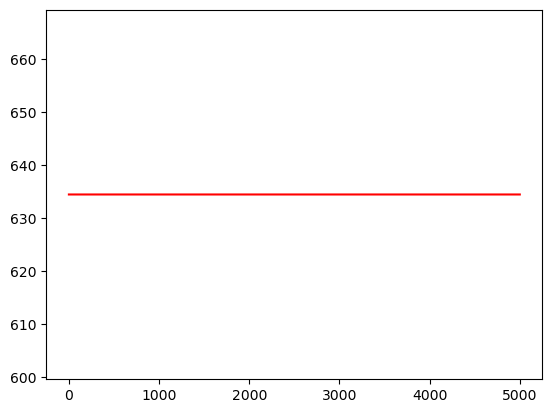

[array([], dtype=float64),
 array([[ 0.24835708, -0.06913215,  0.32384427,  0.76151493, -0.11707669,
         -0.11706848,  0.78960641,  0.38371736, -0.23473719,  0.27128002,
         -0.23170885, -0.23286488,  0.12098114, -0.95664012, -0.86245892,
         -0.28114376],
        [-0.50641556,  0.15712367, -0.45401204, -0.70615185,  0.73282438,
         -0.11288815,  0.0337641 , -0.71237409, -0.27219136,  0.05546129,
         -0.57549679,  0.18784901, -0.30031934, -0.14584687, -0.30085331,
          0.92613909],
        [-0.00674861, -0.52885546,  0.41127246, -0.61042182,  0.1044318 ,
         -0.97983506, -0.66409302,  0.09843062,  0.36923329,  0.08568414,
         -0.05782414, -0.15055185, -0.739261  , -0.3599221 , -0.23031939,
          0.52856111],
        [ 0.17180914, -0.88152008,  0.16204198, -0.19254114, -0.338461  ,
          0.30583814,  0.51549976,  0.46564006, -0.41960876, -0.15460619,
          0.16563172,  0.48777256, -0.23958712, -0.09282949, -0.55316749,
         -0.5981

In [120]:
modelo = MLP([8, 16, 8, 4, 2], 0.001) 
modelo.train(X=X_train2, Z=Z_train2, epochs=5000, batch_size=len(X_train2))

Si analizamos la curva de error a medida que pasan las *epochs*, notamos que el modelo no parece estar mejorando en su eficiencia.

In [112]:
S_values = [[8, 8, 8, 8, 2], [8, 32, 16, 2], [8, 32, 16, 8, 2], [8, 32, 16, 8, 4, 2]]
b_size_values = [X_train2.shape[0]]  
lr_values = [0.01, 0.001, 0.0001]  
epoch_values = [2000, 5000, 10000]                  

params = {
    'b_size': b_size_values,
    'lr': lr_values,
    'epochs': epoch_values,
    'S': S_values
}

grid_search(X_train2, Z_train2, X_val2, Z_val2, N=8, M=2, params=params)

 El mínimo error obtenido es: 56.483090749860956
Usando los parámetros: S: [8, 8, 8, 8, 2], b_size: 400, lr: 0.001, epoch: 2000


Los mejores parámetros encontrados para la red son:

- Usar 3 **capas ocultas**, con 8 nodos cada una.
- **Learning rate** de 0.001.
- 2000 **epochs**

Por último, testeamos nuestro modelos con el conjunto de test, usando los hiperparámetros que minimizan el error.

0 592.8329281621352
100 94.92028614092871
200 94.91470076106343
300 94.91518122397274
400 94.91933347956392
500 94.96394866703928
600 94.96572555432242
700 94.9677274777403
800 94.97002961599395
900 94.9727815570511
1000 94.9764552772781
1100 96.54183899329553
1200 96.59514690419005
1300 96.37960251099517
1400 96.33558802631899
1500 96.33224353004964
1600 96.29435502128737
1700 96.29369918948677
1800 96.2929792839626
1900 96.29225135943118


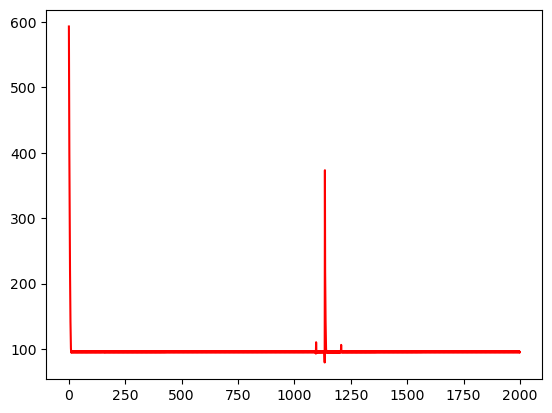

51.879140617290034

In [129]:
modelo_final2 = MLP([8, 8, 8, 8, 2], 0.001)
modelo_final2.train(X=X_train2, Z=Z_train2, epochs=2000, batch_size=len(X_train2))
modelo_final2.validation(X=X_test2, Z=Z_test2)

En este caso, el error para el conjunto de testing es **más bajo** que el de validación, que a su vez es menor al de entrenamiento. Además, la curva del error a lo largo de las *epochs* es casi completamente plana, lo cual implica que el proceso de entrenamiento no realiza ninguna actualización que mejore el comportamiento del modelo.

Nosotras creemos que esto es un indicio de un error de implementación en nuestro código que no logramos resolver.

## Conclusión

Para el problema de clasificación, a pesar de no tener un error tan bajo como esperábamos, nuestro modelo parece haber aprendido patrones en los datos que le permitieron predecir las instancias relativamente bien.

Por otro lado, en el de regresión, no pudimos obtener un modelo que se entrenara correctamente. Creemos que esto es una limitación implementativa de la clase `MLP`, pero no logramos identificar y resolver el error.